# Week 1: MLP from Scratch (NumPy) — XOR

Objectives:
- Implement a 2-layer MLP for XOR
- Train with SGD and visualize loss
- Compare with the PyTorch version in `02_pytorch_mlp.ipynb`

Run locally or in Colab. Ensure the repo dependencies are installed (see README).


epoch= 100 loss=0.6396
epoch= 200 loss=0.5474
epoch= 300 loss=0.3960
epoch= 400 loss=0.2420
epoch= 500 loss=0.1445
epoch= 600 loss=0.0934
epoch= 700 loss=0.0659
epoch= 800 loss=0.0497
epoch= 900 loss=0.0393
epoch=1000 loss=0.0322
epoch=1100 loss=0.0272
epoch=1200 loss=0.0234
epoch=1300 loss=0.0205
epoch=1400 loss=0.0182
epoch=1500 loss=0.0163
epoch=1600 loss=0.0148
epoch=1700 loss=0.0135
epoch=1800 loss=0.0124
epoch=1900 loss=0.0115
epoch=2000 loss=0.0107

Predictions (probabilities):
 [[0.003]
 [0.988]
 [0.988]
 [0.015]]
Binary predictions: [0, 1, 1, 0]


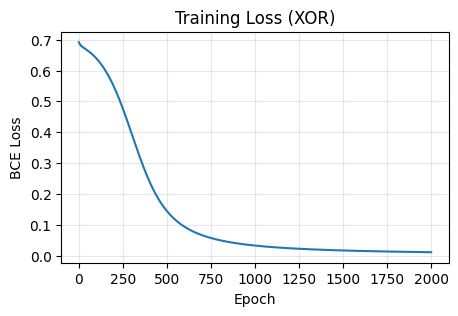

In [2]:
import math
from dataclasses import dataclass
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# XOR dataset
X = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])
y = np.array([[0.0], [1.0], [1.0], [0.0]])

@dataclass
class MLPConfig:
    input_dim: int = 2
    hidden_dim: int = 8
    output_dim: int = 1
    learning_rate: float = 0.1
    num_epochs: int = 2000


def glorot_uniform(fan_in: int, fan_out: int) -> np.ndarray:
    limit = math.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, size=(fan_in, fan_out)).astype(np.float64)


def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid_derivative(x: np.ndarray) -> np.ndarray:
    s = sigmoid(x)
    return s * (1.0 - s)


def tanh_derivative(x: np.ndarray) -> np.ndarray:
    t = np.tanh(x)
    return 1.0 - t ** 2


class TwoLayerMLP:
    def __init__(self, config: MLPConfig):
        self.config = config
        self.W1 = glorot_uniform(config.input_dim, config.hidden_dim)
        self.b1 = np.zeros((1, config.hidden_dim), dtype=np.float64)
        self.W2 = glorot_uniform(config.hidden_dim, config.output_dim)
        self.b2 = np.zeros((1, config.output_dim), dtype=np.float64)

    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, dict]:
        z1 = X @ self.W1 + self.b1
        h1 = np.tanh(z1)
        z2 = h1 @ self.W2 + self.b2
        y_hat = sigmoid(z2)
        cache = {"X": X, "z1": z1, "h1": h1, "z2": z2, "y_hat": y_hat}
        return y_hat, cache

    def backward(self, cache: dict, y_true: np.ndarray) -> None:
        X, z1, h1, z2, y_hat = (
            cache["X"],
            cache["z1"],
            cache["h1"],
            cache["z2"],
            cache["y_hat"],
        )
        # Binary cross-entropy derivative with sigmoid output: dL/dz2 = y_hat - y
        dz2 = (y_hat - y_true) / y_true.shape[0]
        dW2 = h1.T @ dz2
        db2 = dz2.sum(axis=0, keepdims=True)

        dh1 = dz2 @ self.W2.T
        dz1 = dh1 * tanh_derivative(z1)
        dW1 = X.T @ dz1
        db1 = dz1.sum(axis=0, keepdims=True)

        # Gradient descent update
        lr = self.config.learning_rate
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    @staticmethod
    def bce_loss(y_hat: np.ndarray, y_true: np.ndarray) -> float:
        eps = 1e-9
        loss = -(
            y_true * np.log(y_hat + eps) + (1.0 - y_true) * np.log(1.0 - y_hat + eps)
        ).mean()
        return float(loss)


def train(model: TwoLayerMLP, X: np.ndarray, y: np.ndarray) -> list[float]:
    losses: list[float] = []
    for epoch in range(model.config.num_epochs):
        y_hat, cache = model.forward(X)
        loss = model.bce_loss(y_hat, y)
        model.backward(cache, y)
        if (epoch + 1) % 100 == 0:
            print(f"epoch={epoch+1:4d} loss={loss:.4f}")
        losses.append(loss)
    return losses


config = MLPConfig()
model = TwoLayerMLP(config)
losses = train(model, X, y)

# Predictions
with np.printoptions(precision=3, suppress=True):
    y_hat, _ = model.forward(X)
    print("\nPredictions (probabilities):\n", y_hat)
    print("Binary predictions:", (y_hat > 0.5).astype(int).ravel().tolist())

# Plot loss
plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Training Loss (XOR)")
plt.grid(True, alpha=0.3)
plt.show()
